# Load Grocery Dataset

In [10]:
import os
from tqdm import tqdm
import imageio
from pathlib import Path
from skimage.transform import resize
import random
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data_path = "../../data/grocery/images/"

categories = [f for f in os.listdir(data_path) if not f.startswith('.')]

if not isinstance(data_path, Path):
    data_path = Path(data_path)
        
images = []
labels = []

imgsize = 224

for c in tqdm(categories):
    for filename in sorted(data_path.joinpath(c).glob('*.png')):
        image = imageio.imread(filename)
#         image = Image.fromarray(image).resize((128, 128))
        image = resize(image, (imgsize, imgsize))
        images.append(image)
        labels.append(c)

100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


In [4]:
data_tuples = [(images[i], labels[i]) for i in range(len(images))]

In [3]:
def show_random_images(data, title=None):
    sample_images = random.sample(data, 16)
    
    fig, ax = plt.subplots(4,4, figsize=(14,14))
    idx = 0
    for i in range(0,4):
        for j in range(0,4):
            ax[i,j].imshow(sample_images[idx][0])
            ax[i,j].set_title(sample_images[idx][1])
            idx+=1
    plt.plot()           

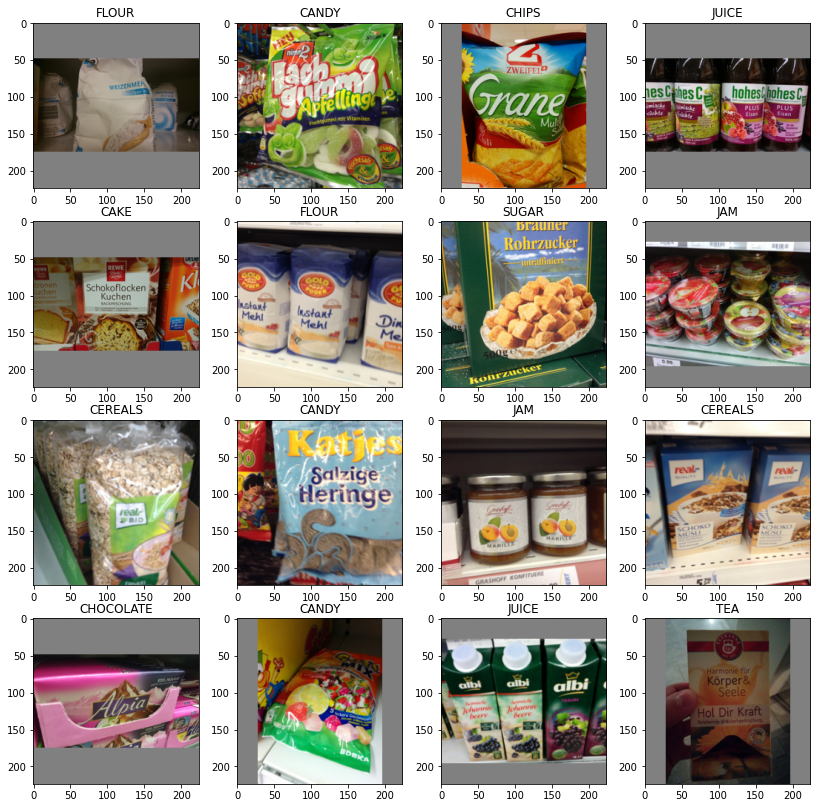

In [5]:
show_random_images(data_tuples)

In [6]:
unique_labels = set(categories)
d= {c:labels.count(c) for c in labels}

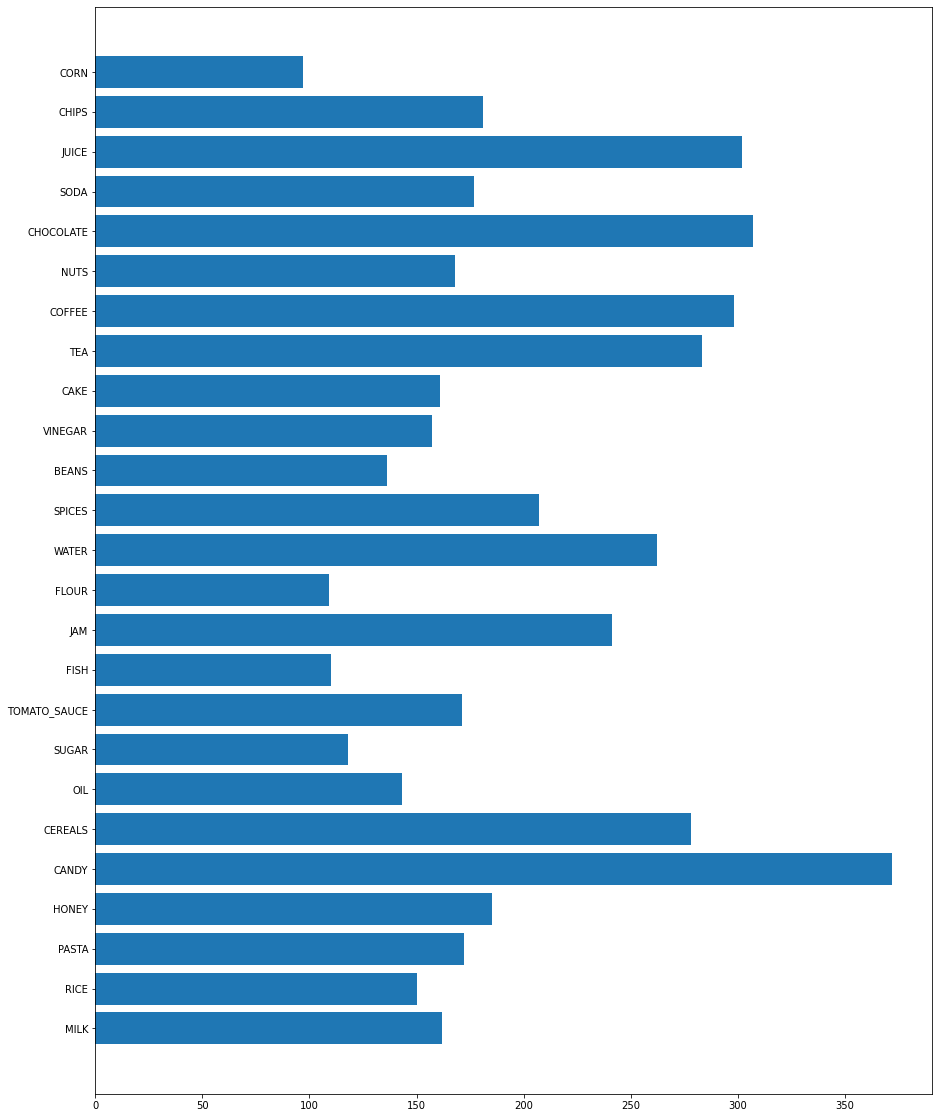

In [7]:
plt.figure(figsize=(15,20))
plt.barh(*zip(*d.items()))
plt.show()

In [8]:
f = open("../../models/grocery_tf_model/labels.txt", "r")
class_labels = [x.strip() for x in f.readlines()]
labels_dict = {v: k for v, k in enumerate(class_labels)}

# TensorFlow Model

In [11]:
import tensorflow as tf
from aidefender.models import CustomVisionTensorFlowModel
print(tf.__version__)

1.15.0


In [12]:
model_path = '../../models/grocery_tf_model'
tf_model = CustomVisionTensorFlowModel(model_path)

[]

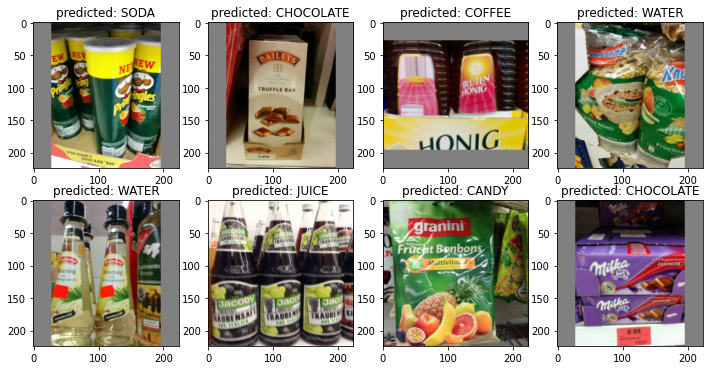

In [13]:
sample = random.sample(data_tuples, 8)
main_label = []
predicted_label = []

fig, ax = plt.subplots(2,4, figsize=(12,6))
idx = 0
for i in range(0,2):
    for j in range(0,4):
        im, label = sample[idx]
        ax[i,j].imshow(im)
        im = np.expand_dims(im, axis=0)*255
        pred = labels_dict[np.argmax(tf_model.predict(im), axis=1)[0]]
        predicted_label.append(pred)
        main_label.append(label)
        ax[i,j].set_title('predicted: {}'.format(pred))
        idx+=1
plt.plot()   

## Performance

In [2]:
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix, classification_report
from aidefender.attacks import FastGradientSignAttack, ProjectedGradientDescentAttack

softmax = lambda x:np.exp(x)/sum(np.exp(x))

def evaluate_model(test_images, test_labels, classifier):
    probas = softmax(classifier.predict(test_images))
    predicted_labels = [labels_dict[label_idx] for label_idx in np.argmax(probas, axis=1)]
    
    accuracy = accuracy_score(predicted_labels,test_labels)
    print('\n Accuracy_score for %s = %s \n'%("TensorFlow Model",accuracy))
    cls = classification_report(predicted_labels,test_labels)
    print(cls)
    
    print("Generating Adversarial images.....")
    
    attack = FastGradientSignAttack()
    samples_adv = attack.run(tf_model, test_images)
    
    probas = softmax(classifier.predict(samples_adv))
    predicted_labels_adv = [labels_dict[label_idx] for label_idx in np.argmax(probas, axis=1)]
    
    accuracy = accuracy_score(predicted_labels_adv,test_labels)
    print('\n Accuracy_score for %s = %s \n'%("TensorFlow Model after FGSM attack",accuracy))
    cls = classification_report(predicted_labels_adv,test_labels)
    print(cls)

In [3]:
samples = random.sample(data_tuples, 500)
test_images = np.array([item[0] for item in samples])
test_labels = [item[1] for item in samples]

NameError: name 'random' is not defined

In [ ]:
evaluate_model(test_images*255, test_labels, tf_model)

## Robustness

In [15]:
# from aidefender.robustness import robustness_accuracy
from art.metrics.metrics import get_crafter

def robustness_accuracy_mine(classifier, x, attack_name, attack_params=None):
    attack = get_crafter(classifier, attack_name, attack_params)

    x_adv = attack.generate(x)
    y_pred = classifier.predict(x, batch_size=1)
    y_pred_adv = classifier.predict(x_adv, batch_size=1)

    labels = y_pred.argmax(axis=1)
    labels_adv = y_pred_adv.argmax(axis=1)
#     print(labels)
#     print(labels_adv)
    robustness_acc = (labels == labels_adv).sum() / labels.shape[0]

    return robustness_acc

In [16]:
robustness = robustness_accuracy_mine(tf_model.classifier, test_images*255, 'fgsm', {"batch_size":1})

print("Robustness of TensorFlow Model is: {}".format(robustness))

Robustness of TensorFlow Model is: 0.11


# PyTorch Model

In [17]:
from art.estimators.classification import PyTorchClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

class GroceryNet(nn.Module):
    def __init__(self, module_name= "densenet", input_dim=768, num_classes=25):
        super(GroceryNet, self).__init__()        
        if module_name == "densenet":
            self.pretrained = models.densenet161(pretrained=True)
            self.set_parameter_requires_grad()
            num_features = self.pretrained.classifier.in_features
            self.pretrained.classifier = nn.Linear(num_features, num_classes)
        elif module_name == "mobilenet":
            self.pretrained = models.mobilenet_v3_large(pretrained=True)
            self.set_parameter_requires_grad()
            num_features = self.pretrained.classifier[3].in_features
            self.pretrained.classifier[3] = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        x = self.pretrained(x)
        return x
    
    def set_parameter_requires_grad(self, feature_extracting=True):
        if feature_extracting:
            for param in self.pretrained.parameters():
                param.requires_grad = False

torch_model_path = "../../models/grocery_net_mobilenet.pt"

model = GroceryNet(module_name="mobilenet")
optimizer = optim.Adam(model.parameters(), lr=0.01)

checkpoint = torch.load(torch_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

# model_t = torch.load(torch_model_path)
# model_t = torch_model.eval()

In [18]:
criterion = nn.CrossEntropyLoss()

torch_model = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    input_shape=(3, 224, 224),
    loss = criterion,
    optimizer=optimizer,
    nb_classes=25,
)

In [20]:
labels_dict

{0: 'BEANS',
 1: 'CAKE',
 2: 'CANDY',
 3: 'CEREALS',
 4: 'CHIPS',
 5: 'CHOCOLATE',
 6: 'COFFEE',
 7: 'CORN',
 8: 'FISH',
 9: 'FLOUR',
 10: 'HONEY',
 11: 'JAM',
 12: 'JUICE',
 13: 'MILK',
 14: 'NUTS',
 15: 'OIL',
 16: 'PASTA',
 17: 'RICE',
 18: 'SODA',
 19: 'SPICES',
 20: 'SUGAR',
 21: 'TEA',
 22: 'TOMATO_SAUCE',
 23: 'VINEGAR',
 24: 'WATER'}

## Performance

In [24]:
from art.attacks.evasion import FastGradientMethod

def evaluate_torch_model(test_images, test_labels, classifier):
    probas = softmax(classifier.predict(test_images))
    predicted_labels = [labels_dict[label_idx] for label_idx in np.argmax(probas, axis=1)]
    accuracy = accuracy_score(predicted_labels,test_labels)
    print('\n Accuracy_score for %s = %s \n'%("PyTorch Model",accuracy))
    cls = classification_report(predicted_labels,test_labels)
    print(cls)
    
    print("Generating Adversarial images.....")
    attack = FastGradientMethod(estimator=classifier, eps=0.2, batch_size=1)
    samples_adv = attack.generate(x=test_images)
    
    probas = softmax(classifier.predict(samples_adv))
    predicted_labels_adv = [labels_dict[label_idx] for label_idx in np.argmax(probas, axis=1)]
    
    accuracy = accuracy_score(predicted_labels_adv,test_labels)
    print('\n Accuracy_score for %s = %s \n'%("PyTorch Model after FGSM attack",accuracy))
    cls = classification_report(predicted_labels_adv,test_labels)
    print(cls)

In [ ]:
test_images_torch = np.transpose(test_images, (0, 3, 1, 2)).astype(np.float32)
evaluate_torch_model(test_images_torch, test_labels, torch_model)


 Accuracy_score for PyTorch Model = 0.676 

              precision    recall  f1-score   support

       BEANS       0.62      1.00      0.76         8
        CAKE       0.40      1.00      0.57         6
       CANDY       0.69      1.00      0.82        27
     CEREALS       0.88      0.43      0.57        54
       CHIPS       0.62      0.81      0.70        16
   CHOCOLATE       0.56      0.40      0.47        35
      COFFEE       0.58      0.72      0.64        25
        CORN       1.00      0.67      0.80         6
        FISH       0.70      0.93      0.80        15
       FLOUR       0.56      0.29      0.38        17
       HONEY       0.88      0.71      0.79        21
         JAM       0.58      1.00      0.74        14
       JUICE       0.93      0.50      0.65        50
        MILK       1.00      0.87      0.93        15
        NUTS       0.57      1.00      0.73        16
         OIL       0.82      0.67      0.74        21
       PASTA       0.77      0.57   

## Robustness

In [ ]:
# robustness = robustness_accuracy_mine(torch_model, test_images_torch, 'fgsm', {"batch_size":1})
# print("Robustness of PyTorch Model is: {}".format(robustness))

# Defense

In [ ]:
from art.defences.preprocessor import SpatialSmoothing, FeatureSqueezing
from art.defences.postprocessor import ReverseSigmoid, GaussianNoise, HighConfidence

ss = SpatialSmoothing(window_size=4)
rs = HighConfidence(cutoff = 0.25)

tf_model.classifier.preprocessing_defences = [ss]
tf_model.classifier.postprocessing_defences = [rs]

In [ ]:
evaluate_model(test_images*255, test_labels, tf_model)

In [ ]:
robustness = robustness_accuracy_mine(tf_model.classifier, test_images*255, 'fgsm', {"batch_size":1})

print("Robustness of TensorFlow Model is: {}".format(robustness))

In [ ]:
ss = SpatialSmoothing(window_size=4)
rs = HighConfidence(cutoff = 0.25)

torch_model.preprocessing_defences = [ss]
torch_model.postprocessing_defences = [rs]

In [ ]:
evaluate_torch_model(test_images_torch, test_labels, torch_model)

## Adversarial Training

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_tuples, test_size=0.2)

In [ ]:
labels_dict_indices = {v:k for k, v in labels_dict.items()}

In [ ]:
x_train = np.array([item[0] for item in train])
y_train = np.array([labels_dict_indices[item[1]] for item in train])
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)

x_test = np.array([item[0] for item in test])
y_test = np.array([labels_dict_indices[item[1]] for item in test])
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [ ]:
# torch_model.fit(x_train, y_train, batch_size=128, nb_epochs=10)

In [ ]:
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer, AdversarialTrainerMadryPGD

attacks = BasicIterativeMethod(torch_model, eps=0.01, eps_step=0.01, max_iter=40)
trainer = AdversarialTrainer(torch_model, attacks, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=2, batch_size=128)

In [ ]:
y_test_labels = [item[1] for item in test]
evaluate_torch_model(x_test, y_test_labels, torch_model)